In [451]:
import json
import math
import numpy as np
import os
import pandas as pd
import random
import requests
import shlex
import subprocess
import sys
import time
import uuid
from pathlib import Path
from PIL import ImageFont, ImageDraw, Image

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import display
import seaborn as sns

import multiprocessing as mp

# set seed
random.seed(42)
np.random.seed(42)

In [452]:
script_palette = {"Arabic": "C0", "Chinese (simplified)": "C5", "Hangul": "C2", "Cyrillic": "C3", "Latin": "C1","Bengali–Assamese": "C4", "Devanagari": "C6","Tamil (Brahmic)": "C9","Telugu":"C8"}
sns.set_context("paper")
sns.set_style("darkgrid")

In [468]:
HOME_DIR = Path("./").expanduser() # change if putting notebook diff folder
data_dir = HOME_DIR / Path("./data/")
DOC_DIR = HOME_DIR / 'doc'


# CHANGE RESULTS FILE
#RESULTS_FILE = data_dir / "./results-530words-500iter.txt"
#RESULTS_FILE = data_dir / "./results-530words-1000iter-width-matched.txt"
RESULTS_FILE = data_dir / "./results-530words-5000iter.txt"

In [467]:
def split_group_tuples(df):

    df["tuple1"],df["tuple2"] = df.group_name_list.str
    df["language1"],df["script1"] = df.tuple1.str
    df["language2"],df["script2"] = df.tuple2.str
    df = pd.concat([df.reset_index(drop=True), pd.DataFrame(df["stats"].to_list(), columns=['stats1', 'stats2'])],axis=1)
    return df


def swap_group_order(df_filt,swap_lang=["English"]):
    #ind = df_filt.eval("language2 == @swap_lang").copy()
    ind = df_filt['group_name_list'].apply(lambda x: any(set(x[1]).intersection(swap_lang)))
    df_filt.loc[ind,"group_name_list"] = df_filt.loc[ind,"group_name_list"].apply(lambda x: tuple(reversed(x))).copy()
    df_filt.loc[ind,"stats"] = df_filt.loc[ind,"stats"].apply(lambda x: list(reversed(x))).copy()

    return df_filt

In [469]:
# code borrowed
import ast
import pickle

all_dicts = []
with open(RESULTS_FILE, "r") as f: # CHANGE FILE FOR 500/5000 iteration runs
    lines = f.read().split("\n")
for i, l in enumerate(lines):
    if not l.strip():
        continue
    try:
        l = l.replace("array", "").replace("dict_keys", "").replace("\n", "")
        all_dicts.append(ast.literal_eval(l))
    except:
        print(
            f"Cannot read dictionary from line {i} (maybe empty line if nothing shows after this, e.g. last line):",
            l,
        )

df_all = pd.DataFrame(all_dicts)

## other functions

In [460]:
# modified from original repo
def plot_pairwise_stats_language(
    stat_dict,
    figsize=None,
    setting_name="unknown",
    num_iteration="unknown",
    confidence_interval_err=2,
    middle_band_width=0.1,
    x_label_angle=10,
    annotate=False,
    title_lang="",
    palette="",
    save_title=""
):
    """
  Given a dictionary of pairs of group and comparison statisitcs:
  ('group1', 'group2'): [num_group1_is_picked, num_group2_is_picked]
  Plot the bar graph on all pairs in this format on the probability p that group1 is picked.
  
  The std error is assumed to be sqrt(p(1-p)/n), a confidence interval for Bernoulli inference.
  The bar graph plot +- 2 std err, giving 95% confidence interval.
  
  Args:
      confidence_interval_err: the width of the confidence interval in the plotsetting_name: the setting of this experiment. Only used for the title of the plot and name of the saved figure
      num_iteration: the number of samples used (int or str). Only used for the title of the plot and name of the saved figure
      x_label_angle: angle to rotate the x label. May need to increase for lengthy labels.
      middle_band_width: add two horizontal lines above and below 0.5 symmetrically to the plot, so creating a band of given width.
                    If None, no line is added.
  """
    x_labels = [pair[1][0] for pair in stat_dict.keys()]
    
    script_labels = [pair[1][1] for pair in stat_dict.keys()]
      #x_labels = ["{}-{}".format(*pair[0]) + "\nhigher than\n" + "{}-{}".format(*pair[1])
      #            for pair in stat_dict.keys()]
    prob = [val[0] / (val[0] + val[1]) for val in stat_dict.values()]
    total = [(val[0] + val[1]) for val in stat_dict.values()]
    y_err = [
        confidence_interval_err * math.sqrt(p * (1 - p) / n)
        for p, n in zip(prob, total)
    ]
    fig, ax = plt.subplots(figsize=figsize)
    #ax.bar(x_labels, np.array(prob) - 0.5, yerr=y_err, color=bar_colors)
    sns.barplot(x=x_labels,y=np.array(prob) - 0.5, yerr=y_err, hue = script_labels,dodge=False,palette=script_palette)
    if annotate:
        for i, v in enumerate(prob):
            y = (max(prob) + 0.05) if v > 0.5 else (min(prob) - 0.2)
            y = y - 0.5
            ax.text(
                i,
                y,
                f"{100*((v-0.5)):.0f}%",
                color="red",
                fontweight="bold",
                fontsize=16,
                ha="center",
            )

    if middle_band_width is not None:
        ax.axhline(0, color="k", label=f"Parity")
    plt.xlim(-0.5, len(x_labels) - 0.5)
    plt.ylim(-0.6, 0.7)
    ax.set_ylabel("Probability - 0.5\n$\pm$ 2 * error", fontsize=20)
    sns.despine(offset=10)
    plt.xticks(rotation=x_label_angle, fontsize=16)
    plt.yticks(fontsize=16)
    ax.yaxis.grid(True)
    plt.legend(fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f"{title_lang} vs. other languages/writing systems, \n {num_iteration} samples", fontsize=20)
    plt.tight_layout()
    #plt.savefig(setting_name + "_n=" + str(num_iteration) + ".jpg")
    
    plt.savefig(DOC_DIR / f"{save_title}.jpeg", bbox_inches = "tight")

# Example filtering
not necesary to run the plot code

In [159]:
# EXAMPLE FILTER: by split tuple
lang='English'
df_filt_example = df_results.query("language1 == @lang or language2 == @lang").sort_values('stats1',ignore_index=True,ascending=False)

,group_name_list,stats,num_iterations,setting,tuple1,tuple2,language1,script1,language2,script2,stats1,stats2
0,"((English, Latin), (Chinese, Chinese (simplifi...","[490.0, 10.0]",500,10lang_530strings,"(English, Latin)","(Chinese, Chinese (simplified))",English,Latin,Chinese,Chinese (simplified),490.0,10.0
1,"((English, Latin), (Arabic, Arabic))","[408.0, 92.0]",500,10lang_530strings,"(English, Latin)","(Arabic, Arabic)",English,Latin,Arabic,Arabic,408.0,92.0
2,"((English, Latin), (Korean, Hangul))","[399.0, 101.0]",500,10lang_530strings,"(English, Latin)","(Korean, Hangul)",English,Latin,Korean,Hangul,399.0,101.0
3,"((English, Latin), (Hindi, Devanagari))","[397.0, 103.0]",500,10lang_530strings,"(English, Latin)","(Hindi, Devanagari)",English,Latin,Hindi,Devanagari,397.0,103.0
4,"((English, Latin), (Bengali, Bengali–Assamese))","[391.0, 109.0]",500,10lang_530strings,"(English, Latin)","(Bengali, Bengali–Assamese)",English,Latin,Bengali,Bengali–Assamese,391.0,109.0
5,"((English, Latin), (Telugu, Telugu))","[301.0, 199.0]",500,10lang_530strings,"(English, Latin)","(Telugu, Telugu)",English,Latin,Telugu,Telugu,301.0,199.0
6,"((English, Latin), (Vietnamese, Latin))","[271.0, 229.0]",500,10lang_530strings,"(English, Latin)","(Vietnamese, Latin)",English,Latin,Vietnamese,Latin,271.0,229.0
7,"((English, Latin), (Swahili, Latin))","[225.0, 275.0]",500,10lang_530strings,"(English, Latin)","(Swahili, Latin)",English,Latin,Swahili,Latin,225.0,275.0
8,"((English, Latin), (Spanish, Latin))","[223.0, 277.0]",500,10lang_530strings,"(English, Latin)","(Spanish, Latin)",English,Latin,Spanish,Latin,223.0,277.0
9,"((English, Latin), (Russian, Cyrillic))","[209.0, 291.0]",500,10lang_530strings,"(English, Latin)","(Russian, Cyrillic)",English,Latin,Russian,Cyrillic,209.0,291.0


In [ ]:
# EXAMPLE FILTER: by full group_names
names =[(('Arabic', 'Arabic'), ('Hindi', 'Devanagari'))]
df_filter_example.query('group_name_list in @names')

# PLOTS: 530 common word base set

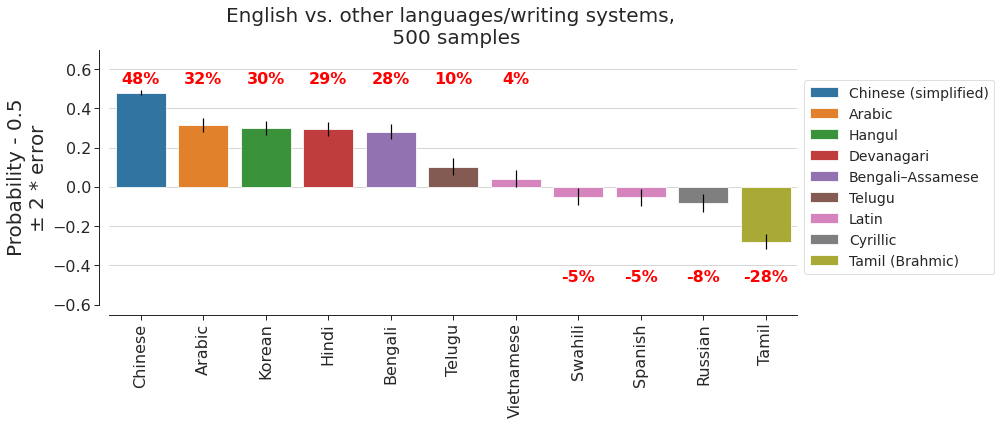

In [223]:
lang=['English']

# functions to make dataframe easier to work with
df_results = swap_group_order(df_all,swap_lang = lang)
df_results = split_group_tuples(df_all)

df_filt = (df_results.query("language1 == @lang or language2 == @lang")
               .sort_values('stats1',ignore_index=True,ascending=False))
stat_dict = (df_filt.set_index("group_name_list")["stats"]
               .to_dict())

NUM_ITERATION = 500
SETTING_NAME = "10lang_530string"
plot_pairwise_stats_language (
    stat_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    middle_band_width=None,
    figsize=(14, 6),
    x_label_angle=90,
    annotate = True,
    title_lang = lang,
    palette=script_palette
)

NOTE: re running with 5000 samples (versus 500 samples) changes some of the pairing comparison. Assume 5,000 reflects better sampling

<ipython-input-467-72e882548a71>:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["tuple1"],df["tuple2"] = df.group_name_list.str
<ipython-input-467-72e882548a71>:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["language1"],df["script1"] = df.tuple1.str
<ipython-input-467-72e882548a71>:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["language2"],df["script2"] = df.tuple2.str


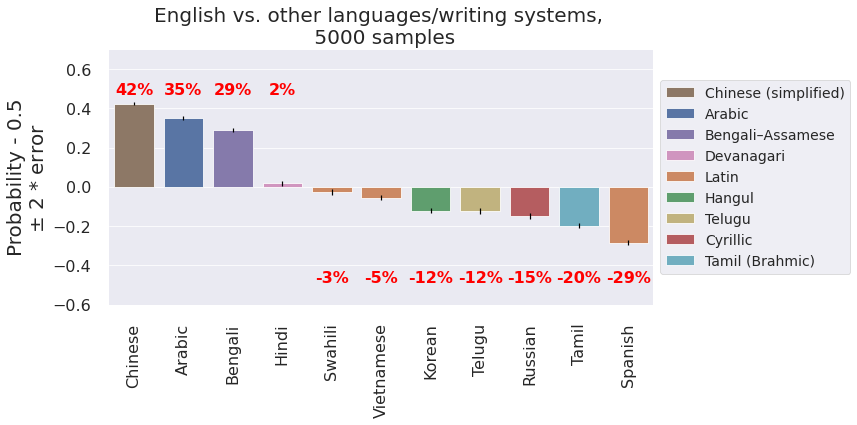

In [471]:
lang=['English']

# functions to make dataframe easier to work with
df_results = swap_group_order(df_all,swap_lang = lang)
df_results = split_group_tuples(df_all)

df_filt = (df_results.query("language1 == @lang or language2 == @lang")
               .sort_values('stats1',ignore_index=True,ascending=False))
stat_dict = (df_filt.set_index("group_name_list")["stats"]
               .to_dict())

NUM_ITERATION = 5000
SETTING_NAME = "10lang_530string"
plot_pairwise_stats_language (
    stat_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    middle_band_width=None,
    figsize=(12, 6),
    x_label_angle=90,
    annotate = True,
    title_lang = lang[0],
    palette=script_palette,
    save_title ="english_parity_plot_base"
)

<ipython-input-467-72e882548a71>:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["tuple1"],df["tuple2"] = df.group_name_list.str
<ipython-input-467-72e882548a71>:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["language1"],df["script1"] = df.tuple1.str
<ipython-input-467-72e882548a71>:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["language2"],df["script2"] = df.tuple2.str


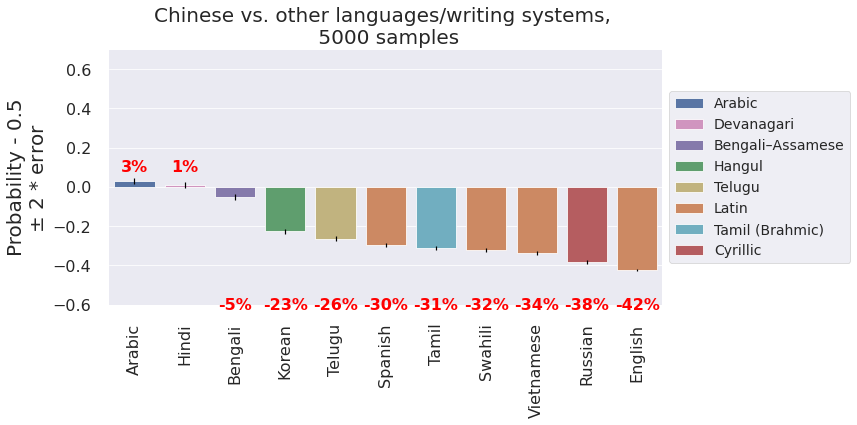

In [474]:
lang=['Chinese']


df_results = swap_group_order(df_all,swap_lang = lang)
df_results = split_group_tuples(df_all)

df_filt = (df_results.query("language1 == @lang or language2 == @lang")
               .sort_values('stats1',ignore_index=True,ascending=False))
stat_dict = (df_filt.set_index("group_name_list")["stats"]
               .to_dict())

NUM_ITERATION = 5000
SETTING_NAME = "10lang_530string"
plot_pairwise_stats_language (
    stat_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    middle_band_width=None,
    figsize=(12, 6),
    x_label_angle=90,
    annotate = True,
    title_lang = lang[0],
    palette=script_palette,
     save_title ="chinese_parity_plot_base"
)

# PLOTS: Matched width text

Here I generate nonesense words randomnly (e.g. 'kdkaoel' or '들의그그의들들') for each language. Added characters until the width of the word, on the generated image, was at least 175 pixels long. This ensures that length of the words have similar distributions across the different languages.

<ipython-input-267-72e882548a71>:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["tuple1"],df["tuple2"] = df.group_name_list.str
<ipython-input-267-72e882548a71>:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["language1"],df["script1"] = df.tuple1.str
<ipython-input-267-72e882548a71>:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["language2"],df["script2"] = df.tuple2.str


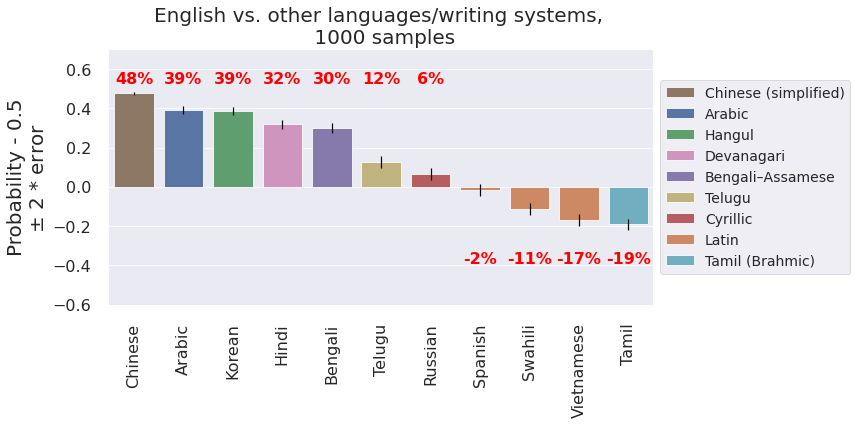

In [462]:
lang=['English']

# functions to make dataframe easier to work with
df_results = swap_group_order(df_all,swap_lang = lang)
df_results = split_group_tuples(df_all)

df_filt = (df_results.query("language1 == @lang or language2 == @lang")
               .sort_values('stats1',ignore_index=True,ascending=False))
stat_dict = (df_filt.set_index("group_name_list")["stats"]
               .to_dict())

NUM_ITERATION = 1000
SETTING_NAME = "10lang_530strings_width_matched"

plot_pairwise_stats_language (
    stat_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    middle_band_width=None,
    figsize=(12, 6),
    x_label_angle=90,
    annotate = True,
    title_lang = lang[0],
    palette=script_palette,czx 
    save_title ="english_parity_plot_WM"
)

# Language preference pooled (width matched images)

In [441]:
lang=["English","Spanish","Vietnamese","Swahili"]

df_results = swap_group_order(df_all,swap_lang = lang)
df_results = split_group_tuples(df_all)

df_results.loc[df_results.eval("script1 =='Latin'"),"is_latin"] = "Latin"
df_results.loc[~df_results.eval("script1 =='Latin'"),"is_latin"] = "Other"

df_results["ratio"] = df_results.stats1/df_results.stats2

<ipython-input-267-72e882548a71>:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["tuple1"],df["tuple2"] = df.group_name_list.str
<ipython-input-267-72e882548a71>:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["language1"],df["script1"] = df.tuple1.str
<ipython-input-267-72e882548a71>:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["language2"],df["script2"] = df.tuple2.str


In [311]:
df_results.query('ratio > 50') # one too darn big to plot

,group_name_list,stats,num_iterations,setting,tuple1,tuple2,language1,script1,language2,script2,stats1,stats2,is_latin,ratio
10,"((Spanish, Latin), (Arabic, Arabic))","[999.0, 1.0]",1000,10lang_530strings_width_matched,"(Spanish, Latin)","(Arabic, Arabic)",Spanish,Latin,Arabic,Arabic,999.0,1.0,Latin,999.0


In [442]:
df_results = df_results.query('ratio < 50') # filter it out


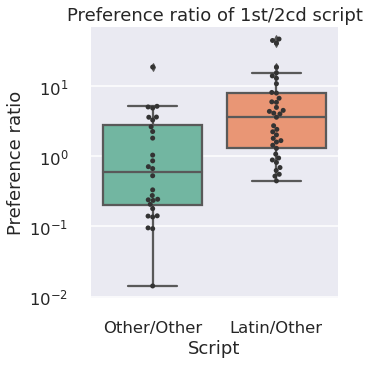

In [448]:
sns.set_style("darkgrid") 
sns.set_context("talk")

fig,ax = plt.subplots(1,figsize=(5,5))
ax.set_yscale("log")

sns.swarmplot(ax=ax, x="is_latin", y="ratio", data=df_results,color = ".2")
sns.boxplot(ax=ax, x="is_latin", y="ratio", data=df_results,palette="Set2")


ax.set_xlabel("Script")
ax.set_ylabel("Preference ratio")

plt.tight_layout()
sns.despine(offset=10)
ax.set_xticklabels(["Other/Other","Latin/Other"])
#plt.legend(fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f"Preference ratio of 1st/2cd script")
plt.savefig(DOC_DIR / f"pref_ratio_latin1st_{SETTING_NAME}.jpeg", bbox_inches = "tight")

In [445]:
import scipy.stats as stats

stats.ttest_ind(df_results.loc[df_results["is_latin"]=="Latin","ratio"],df_results.loc[df_results["is_latin"]=="Other","ratio"])

Ttest_indResult(statistic=2.471192464226488, pvalue=0.016182497642973387)

## total times pick (width matched images)

In [428]:
lang=["English"]

df_results = swap_group_order(df_all,swap_lang = lang)
df_results = split_group_tuples(df_all)

d1 = df_results.loc[:,["language1", "script1", "stats1",]].rename(columns={"language1":"language","script1":"script","stats1":"stats"})
d2 = df_results.loc[:,["language2","script2", "stats2"]].rename(columns={"language2":"language","script2":"script","stats2":"stats"})
df_stack = pd.concat([d1,d2])

<ipython-input-267-72e882548a71>:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["tuple1"],df["tuple2"] = df.group_name_list.str
<ipython-input-267-72e882548a71>:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["language1"],df["script1"] = df.tuple1.str
<ipython-input-267-72e882548a71>:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["language2"],df["script2"] = df.tuple2.str


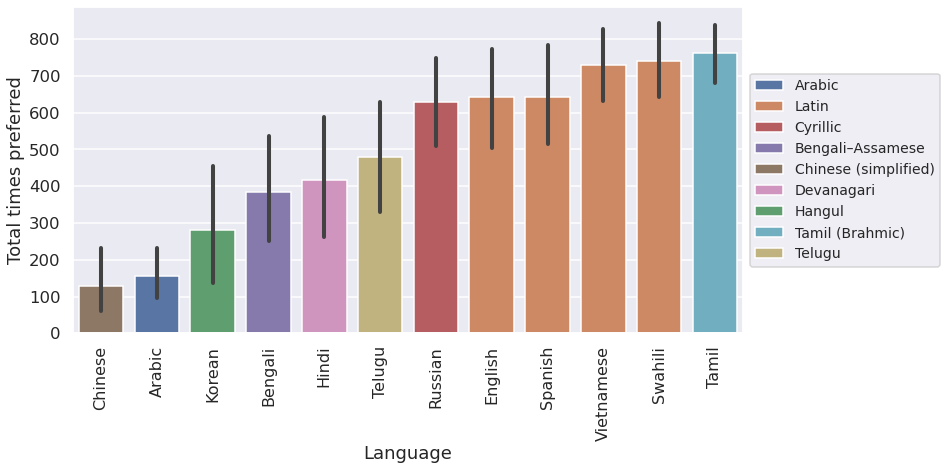

In [449]:
sns.set_palette('deep')

fig, ax = plt.subplots(1,figsize=(12,6))
sns.barplot(ax=ax,  data=df_stack,x="language",y="stats",order=df_stack.groupby("language").mean().sort_values("stats").index,hue="script",dodge=False,palette=script_palette)

ax.set_xlabel("Language")
ax.set_ylabel("Total times preferred")

plt.legend(fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90, fontsize=16)

plt.savefig(DOC_DIR / f"total_pref_{SETTING_NAME}.jpeg", bbox_inches = "tight")

In [437]:
df_stack.language.unique()

array(['Arabic', 'English', 'Spanish', 'Russian', 'Swahili', 'Bengali',
       'Vietnamese', 'Chinese', 'Hindi', 'Korean', 'Tamil', 'Telugu'],
      dtype=object)